# Our Libraries & GPU

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Image manipulation
from PIL import Image
import cv2

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torchvision import models
 
# Sklearn
from sklearn.model_selection import train_test_split

In [2]:
# Check the use of the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Our Data

In [3]:
# Number of classes
dataset_dir = "/kaggle/input/solar-panel-images/Faulty_solar_panel"
dataset = datasets.ImageFolder(root=dataset_dir)
class_names = dataset.classes
class_names

['Bird-drop',
 'Clean',
 'Dusty',
 'Electrical-damage',
 'Physical-Damage',
 'Snow-Covered']

# Dataset

In [4]:
# My custom Solar Dataset class
class SolarDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(dataset_dir))}

        """
        Collectting the image paths and assign labels based on the directory name so we can use them later as we have 8 classes
        """
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith(('jpg', 'jpeg', 'png')):
                        img_path = os.path.join(class_dir, img_file)
                        self.image_paths.append(img_path)
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transforms

In [5]:
# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test a sample

In [6]:
solar_dataset = SolarDataset(dataset_dir=dataset_dir, transform=data_transform)

print(f"Total images: {len(solar_dataset)}")
print(f"Classes found: {solar_dataset.class_to_idx}")

Total images: 807
Classes found: {'Snow-Covered': 0, 'Dusty': 1, 'Electrical-damage': 2, 'Clean': 3, 'Bird-drop': 4, 'Physical-Damage': 5}


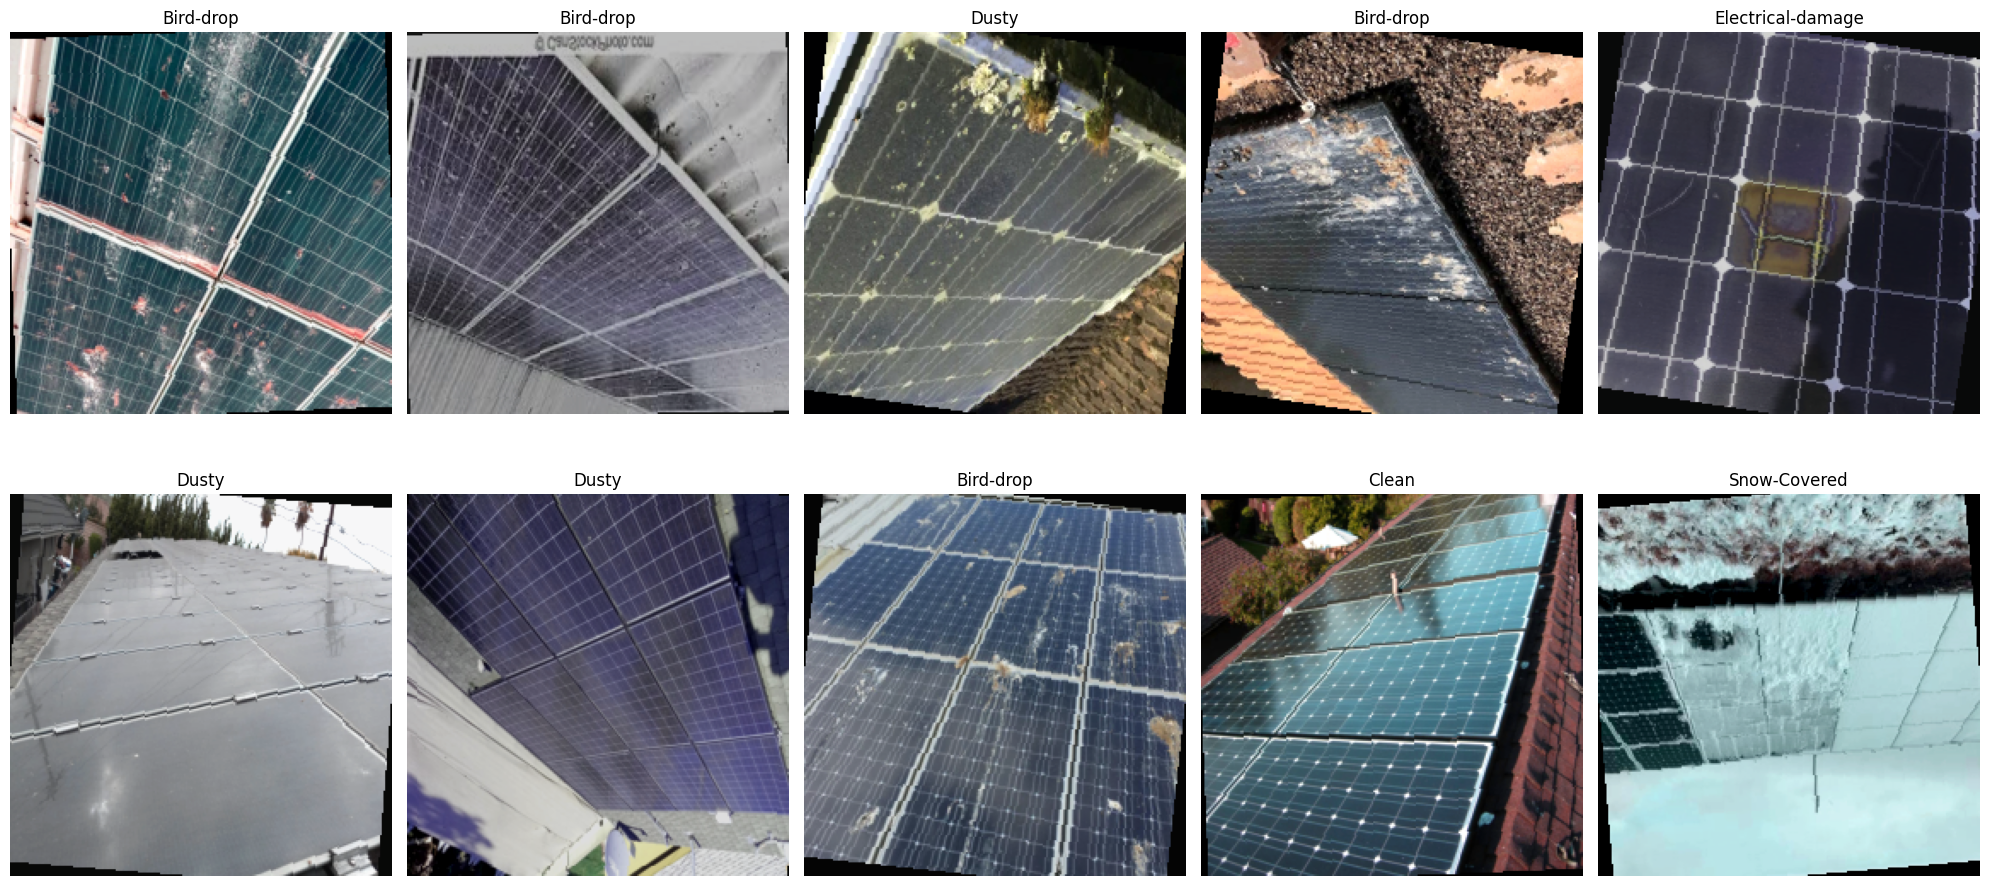

In [7]:
# Display images with their labels after transformation (the data augmentationi did)
def show_random_samples(dataset, class_to_idx, num_samples=10):
    num_columns = num_samples // 2
    fig, axs = plt.subplots(2, num_columns, figsize=(20, 10))
    random_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)
        
        axs[i // num_columns, i % num_columns].imshow(image)
        axs[i // num_columns, i % num_columns].set_title(f"{list(class_to_idx.keys())[label]}")
        axs[i // num_columns, i % num_columns].axis('off')

    plt.tight_layout()
    plt.show()
    
# Testing 10 images
show_random_samples(solar_dataset, solar_dataset.class_to_idx, num_samples=10)

# Split Data

In [8]:
# Split the dataset into training and validation sets
torch.manual_seed(42)
train_size = int(0.7 * len(solar_dataset))
val_size = int(0.15 * len(solar_dataset))
test_size = len(solar_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(solar_dataset, [train_size, val_size, test_size])

# checking on the split
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 564
Validation set size: 121
Test set size: 122


# DataLoaders

In [9]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Modelling

In [10]:
# Our Based Model for Transfer Learning due to the small dataset
model = models.efficientnet_b3(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 173MB/s] 


* i chose efficientnet_b3 due to the small data set
* EfficientNetB3 size : 48
* top 5 acc : 95.7%
* EfficientNetB3 params : 12.3M	

### Transfer learning

In [11]:
# Freeze the params
for parameter in model.parameters():
    parameter.requires_grad = False

# Old Classification head
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

In [12]:
# New Classification head with dropout layer to help with regularization
num_classes = 8

model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### Fine tuning

In [13]:
# Unfreeze the last few layers for fine-tuning
for layer in list(model.children())[-6:]:
    for param in layer.parameters():
        param.requires_grad = True

### Set the model params

In [14]:
# loss function, optimizer, learning rate scheduler and the number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.003)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
num_epochs = 30

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training & Validation Loop

In [24]:
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_loss /= val_total
    val_accuracy = val_correct / val_total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Tuning Rl and doing early stopping to prevent the overfitting
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Saving our best model
        torch.save(model.state_dict(), 'best_model.pth')  
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch [1/30], Loss: 0.1388, Accuracy: 0.9610
Validation Loss: 0.3144, Validation Accuracy: 0.8843
Early stopping triggered after 1 epochs.


# Test loop

In [26]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_outputs = model(test_images)
        loss = criterion(test_outputs, test_labels)
        
        test_loss += loss.item() * test_images.size(0)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == test_labels).sum().item()
        test_total += test_labels.size(0)

test_loss /= test_total
test_accuracy = test_correct / test_total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/tmp/ipykernel_30/572751272.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.3950, Test Accuracy: 0.8852


# Test

In [35]:
# Define the class names to assign them to the predictions from the model
class_names = {
    0: 'Snow-Covered',
    1: 'Dusty',
    2: 'Electrical-damage',
    3: 'Clean',
    4: 'Bird-drop',
    5: 'Physical-Damage'
}

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model.to(device)

# Define the transformation for the image to match the training preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/tmp/ipykernel_30/1840311065.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [36]:
def predict_and_show_image(image_path):
    # Load and preprocess the image in rgb
    image = Image.open(image_path).convert('RGB')
    transformed_image = image_transform(image)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted_idx = torch.max(output, 1)
    predicted_class_name = class_names[predicted_idx.item()]
    # plotting the image with the predicted class
    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()
    
    return predicted_class_name

# Enter the image you want to test

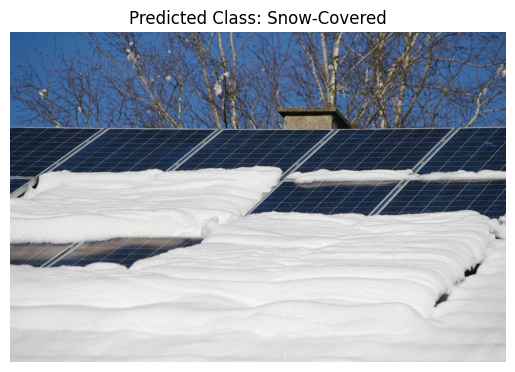

In [37]:
image_path = '/kaggle/input/test-img/s4.jpg'
predicted_class_name = predict_and_show_image(image_path)